In [63]:
THEO_COLUMNS = ['theo_event_tx_timestamp', 'theo_event_tx_timestamp_ns',
                'instrument_hash','tv','delta','vol','vega','under','tte',
                'option_type_name','inst_type_name','strike','term']

In [64]:
import pandas as pd
import numpy as np
import os
import itertools

In [65]:
print(os.getcwd())
data = pd.read_csv('grad_data_2023.csv')
data_22 = data[data['trade_date'] == "2023-05-22"]
data_23 = data[data['trade_date'] == "2023-05-23"]

/home/sohamd/Quantum-Deep-Hedging/src/testing


In [66]:
ewma_10 = data['delta'].ewm(span = 10).mean()
ewma_100 = data['delta'].ewm(span = 100).mean()
ewma_1000 = data['delta'].ewm(span = 1000).mean()
macd = ewma_100 - ewma_1000
signal_line = macd.ewm(span = 500).mean() # higher value closer it tracks

def offset(a):
    ewma_100 = data['delta'].ewm(span = 100).mean()
    ewma_1000 = data['delta'].ewm(span = 1000).mean()
    macd = ewma_100 - ewma_1000
    signal_line = macd.ewm(span = 1000).mean() # higher value closer it tracks

    # Calculate the distance between the indicator and the signal line
    distance = abs(macd-signal_line)


    return -a * (distance ** 2)

#print(offset(5))


# New Section

In [67]:
print(data)

           theo_event_tx_timestamp  trade_date option_type_name      term  \
0       2023-05-22 11:55:02.407195  2023-05-22              PUT  Jun-2023   
1       2023-05-22 12:00:15.409357  2023-05-22              PUT  Jun-2023   
2       2023-05-22 12:01:17.787593  2023-05-22              PUT  Jun-2023   
3       2023-05-22 12:15:15.408862  2023-05-22              PUT  Jun-2023   
4       2023-05-22 12:30:15.408916  2023-05-22              PUT  Jun-2023   
...                            ...         ...              ...       ...   
117840  2023-05-23 20:59:23.835352  2023-05-23              PUT  Jun-2023   
117841  2023-05-23 20:59:30.841632  2023-05-23              PUT  Jun-2023   
117842  2023-05-23 20:59:49.349799  2023-05-23              PUT  Jun-2023   
117843  2023-05-23 20:59:56.839865  2023-05-23              PUT  Jun-2023   
117844  2023-05-23 21:09:19.554959  2023-05-23              PUT  Jun-2023   

        strike        tv     delta     gamma      under       tte      vega

<Axes: >

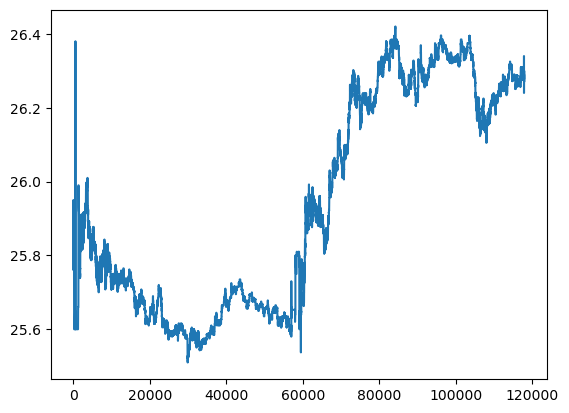

In [68]:
from enum import Enum, auto
data["under"].plot()

In [69]:
class Frequency(str, Enum):
    SNAP = 'snap'
    MINUTE = 'minute'
    HOURLY = 'hour'
    DAILY = 'daily'
    BAND = "band"

$b(a,b,\gamma,t) = \frac{a}{\sqrt{\gamma}} + b*t$

In [70]:
#a*gamma^(1/2) + b*t where a,b are weightings, gamma is gamma (<1), and t is transaction cost

def hbands(a, b, γ, t):
    return a * (γ**(-0.5)) + 1.15*b *t



In [71]:
class Hedger:

    def __init__(self,
                 data: pd.DataFrame,
                 t_cost: float = 5.0,
                 open_time: str = '13:05',
                 close_time: str = '20:50',
                 running_delta = 0,
                 # in basis point
                 ):

        self.running_delta = running_delta
        self.data = data.copy()
        self.t_cost = t_cost
        self.open_time = open_time
        self.close_time = close_time
        self.prepare_data()
        self.running_delta = 0
        self.delta_old = data['delta'].iloc[0]
        self.delta_new = 0
        self.offsets = offset(5)
        self.offsetidx = []


    def prepare_data(self):
        self.data.set_index(pd.DatetimeIndex(self.data['theo_event_tx_timestamp']), inplace=True)
        self.data.sort_index(inplace=True)
        self.data = self.data.between_time(self.open_time, self.close_time)
        self.data['id'] = range(self.data.shape[0])




    def tag_hedge_flags(self, frequency: Frequency):
        if frequency == Frequency.SNAP:
            self.data['hedge_flag'] = True
        else:
            if frequency == Frequency.MINUTE:
                grouper = pd.to_datetime(self.data.index).floor("min")
                self.data['hedge_flag'] = self.data.groupby(grouper)['id'].transform('last') == self.data.id
            elif frequency == Frequency.HOURLY:
                grouper = pd.to_datetime(self.data.index).floor("H")
                self.data['hedge_flag'] = self.data.groupby(grouper)['id'].transform('last') == self.data.id
            elif frequency == Frequency.DAILY:
                grouper = pd.to_datetime(self.data.index).date
                self.data['hedge_flag'] = self.data.groupby(grouper)['id'].transform('last') == self.data.id
            elif frequency == Frequency.BAND:
                for i, delta in self.data['delta'].items():
                    self.delta_new = delta
                    self.running_delta += self.delta_new - self.delta_old


                    if abs(self.running_delta) >= hbands(0.005,0.005,self.data['gamma'].loc[i],5):  # Check the accumulated running_delta
                        self.data.loc[i, 'hedge_flag'] = True
                        self.running_delta = 0
                        #row_index = self.data[self.data[0] == i].index[0]
                        #print("i: ",row_index)
                        #self.offsetidx.append(self.data[i].index[0])

                    else:
                        self.data.loc[i, 'hedge_flag'] = False

                    self.delta_old = self.delta_new



    def _calculate_net_cash(self, prev_delta, new_delta, under):
        if new_delta > prev_delta:
            # buy diff delta amount of underlying
            # offset = self.data['delta'].loc[]
            #CHANGED HERE

            #print(self.offsetidx)

            diff_delta = new_delta - prev_delta# - self.offsets

            #diff_delta = offset(3)
            # fees
            fee = diff_delta * under * self.t_cost / 1e4
            return -diff_delta * under - fee
        else:
            #CHANGED HERE
            # sell diff delta amount of underlying
            diff_delta = prev_delta - new_delta #+ self.offsets
            #print("offset: ",offset(30))
            # fees
            fee = diff_delta * under * self.t_cost / 1e4
            return diff_delta * under - fee

    def calculate(self, frequency: Frequency):
        self.tag_hedge_flags(frequency)
        stock, cash, cash_array, exposure_arr = 0, 0, [], []
        start_print = self.data.iloc[0]
        last_rw = self.data.shape[0] - 1
        for i, rw in self.data.iterrows():
            id = rw['id']
            if id == 0:
                # buy the option
                # hedge the delta by buying stock
                cash = -start_print['tv'] + self._calculate_net_cash(0, -start_print['delta'], start_print['under'])
                stock = -start_print['delta']
            elif rw['hedge_flag'] & (id != last_rw):
                # only hedge if the hedge_flag is true for this snap
                # hedge using stock to get delta neutral
                cash += self._calculate_net_cash(stock, -rw['delta'], rw['under'])
                # update the stock/delta
                stock = -rw['delta']
            elif id == last_rw:
                # sell the option and any stock associated with hedging
                cash += self._calculate_net_cash(stock, 0, rw['under'])
            cash_array.append(cash)
            # amount of deltas which are not hedged
            exposure_arr.append(rw['delta'] + stock)

        self.data[f'{frequency}_cash'] = cash_array
        self.data[f'{frequency}_exposure_arr'] = exposure_arr


In [72]:
cls = Hedger(data=data_23)

In [73]:
cls.calculate(frequency=Frequency.SNAP)
cls.calculate(frequency=Frequency.MINUTE)
cls.calculate(frequency=Frequency.HOURLY)
cls.calculate(frequency=Frequency.DAILY)
cls.calculate(frequency=Frequency.BAND)

/tmp/ipykernel_23836/3315705850.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouper = pd.to_datetime(self.data.index).floor("H")


<Axes: xlabel='theo_event_tx_timestamp'>

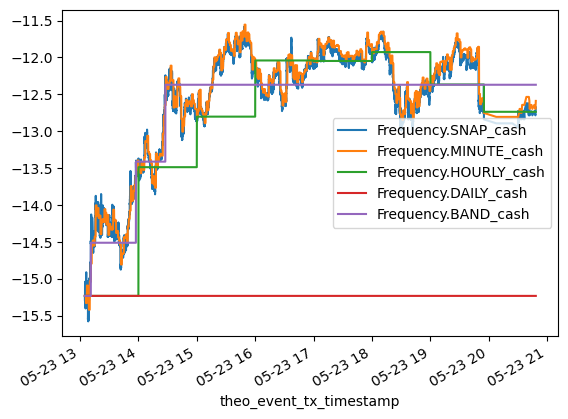

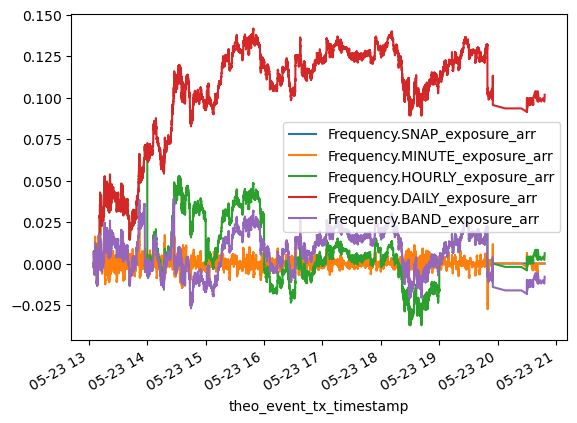

In [78]:
cls.data[['Frequency.SNAP_cash','Frequency.MINUTE_cash','Frequency.HOURLY_cash','Frequency.DAILY_cash', 'Frequency.BAND_cash']][:-1].plot()
cls.data[['Frequency.SNAP_exposure_arr','Frequency.MINUTE_exposure_arr','Frequency.HOURLY_exposure_arr','Frequency.DAILY_exposure_arr','Frequency.BAND_exposure_arr']][:-1].plot()

### Hbands plot

Text(0, 0.5, 'Hband')

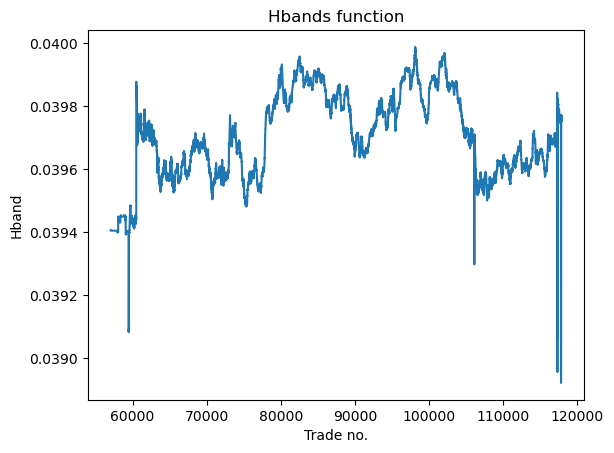

In [75]:
ax = hbands(0.005,0.005,data_23['gamma'],5).plot()
ax.set_title('Hbands function')
ax.set_xlabel('Trade no.')
ax.set_ylabel('Hband')